In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf



In [2]:
class stg_circuit:
    def __init__(self, dt=0.025, T=2400, fft_start=400, w=40):
        self.dt = dt
        self.T = T
        self.fft_start = fft_start
        self.w = w
        V_m0 = -65.0e-3*np.ones((5,))
        N_0 = 0.25*np.ones((5,))
        H_0 = 0.1*np.ones((5,))
        #self.init_conds = np.concatenate((V_m0, N_0, H_0), axis=0)
        self.init_conds = np.array([-0.05396623, -0.02110229, -0.04078849, -0.0585101,  -0.04425548,
               0.0160548, 0.00819903, 0.00140394, 0.02428747, 0.00122073,
               0.10245851,  0.08343522, 0.14188061,  0.0758458,   0.11325111])

    def simulate(self, g_el, g_synA, g_synB):
        # define fixed parameters

        #conductances
        C_m = 1.0e-9

        # volatages
        V_leak = -40.0e-3 # 40 mV
        V_Ca = 100.0e-3 # 100mV
        V_k = -80.0e-3 # -80mV
        V_h = -20.0e-3 # -20mV
        V_syn = -75.0e-3 # -75mV

        v_1 = 0.0 # 0mV
        v_2 = 20.0e-3 # 20mV
        v_3 = 0.0 # 0mV
        v_4 = 15.0e-3 # 15mV
        v_5 = 78.3e-3 # 78.3mV
        v_6 = 10.5e-3 # 10.5mV
        v_7 = -42.2e-3 # -42.2mV
        v_8 = 87.3e-3 # 87.3mV
        v_9 = 5.0e-3  # 5.0mV

        v_th = -25.0e-3 # -25mV

        # neuron specific conductances
        g_Ca_f = 1.9e-2 * (1e-6) # 1.9e-2 \mu S
        g_Ca_h = 1.7e-2 * (1e-6) # 1.7e-2 \mu S
        g_Ca_s = 8.5e-3 * (1e-6) # 8.5e-3 \mu S

        g_k_f  = 3.9e-2 * (1e-6) # 3.9e-2 \mu S
        g_k_h  = 1.9e-2 * (1e-6) # 1.9e-2 \mu S
        g_k_s  = 1.5e-2 * (1e-6) # 1.5e-2 \mu S

        g_h_f  = 2.5e-2 * (1e-6) # 2.5e-2 \mu S
        g_h_h  = 8.0e-3 * (1e-6) # 8.0e-3 \mu S
        g_h_s  = 1.0e-2 * (1e-6) # 1.0e-2 \mu S

        g_Ca = np.array([g_Ca_f, g_Ca_f, g_Ca_h, g_Ca_s, g_Ca_s])
        g_k = np.array([g_k_f, g_k_f, g_k_h, g_k_s, g_k_s])
        g_h = np.array([g_h_f, g_h_f, g_h_h, g_h_s, g_h_s])

        g_leak = 1.0e-4 * (1e-6) # 1e-4 \mu S

        phi_N = 2 # 0.002 ms^-1

        def f(x, g_el, g_synA, g_synB):
            # x contains
            V_m = x[:5]
            N = x[5:10]
            H = x[10:]
            
            M_inf = 0.5*(1.0 + np.tanh((V_m - v_1)/ v_2))
            N_inf = 0.5*(1.0 + np.tanh((V_m - v_3)/v_4))
            H_inf = 1.0 / (1.0 + np.exp((V_m + v_5)/v_6))
                           
            S_inf = 1.0 / (1.0 + np.exp((v_th - V_m) / v_9))
            
            I_leak = g_leak*(V_m - V_leak)
            I_Ca = g_Ca*M_inf*(V_m - V_Ca)
            I_k = g_k*N*(V_m - V_k)
            I_h = g_h*H*(V_m - V_h)
                           
            I_elec = np.array([0.0, 
                               g_el*(V_m[1]-V_m[2]),
                               g_el*(V_m[2]-V_m[1] + V_m[2]-V_m[4]),
                               0.0,
                               g_el*(V_m[4]-V_m[2])])
                           
            I_syn = np.array([g_synB*S_inf[1]*(V_m[0] - V_syn),
                                g_synB*S_inf[0]*(V_m[1] - V_syn),
                                g_synA*S_inf[0]*(V_m[2] - V_syn) + g_synA*S_inf[3]*(V_m[2] - V_syn),
                                g_synB*S_inf[4]*(V_m[3] - V_syn),
                                g_synB*S_inf[3]*(V_m[4] - V_syn)])

            I_total = I_leak + I_Ca + I_k + I_h + I_elec + I_syn    
            
            lambda_N = (phi_N)*np.cosh((V_m - v_3)/(2*v_4))
            tau_h = (272.0 - (-1499.0 / (1.0 + np.exp((-V_m + v_7) / v_8)))) / 1000.0
            
            dVmdt = (1.0 / C_m)*(-I_total)
            dNdt = lambda_N*(N_inf - N)
            dHdt = (H_inf - H) / tau_h
            
            dxdt = np.concatenate((dVmdt, dNdt, dHdt), axis=0)
            return dxdt

        x = self.init_conds
        xs = [x]
        for t in range(self.T):
            dxdt = f(x, g_el, g_synA, g_synB)
            x = dxdt*self.dt + x
            xs.append(x)
        X = np.array(xs)

        return X

    def T_x(self, g_el, g_synA, g_synB):
        def moving_average(a, n=3) :
            ret = np.cumsum(a, dtype=float)
            ret[n:] = ret[n:] - ret[:-n]
            return ret[n - 1:] / n

        # sampling frequency
        Fs  = 1.0 / self.dt 
        # num samples for freq measurement
        N = self.T - self.fft_start + 1 - (self.w-1) 
        
        min_freq = 0.0
        max_freq = 1.0
        num_freqs = 101
        freqs = np.linspace(min_freq, max_freq, num_freqs)

        ns = np.arange(0,N)
        phis = []
        for i in range(num_freqs):
            k = N*freqs[i] / Fs
            phi = np.cos(2*np.pi*k*ns/N) - 1j * np.sin(2*np.pi*k*ns/N)
            phis.append(phi)

        Phi = np.array(phis)

        alpha = 100

        X = self.simulate(g_el, g_synA, g_synB)
        v_h = X[self.fft_start:,2]

        v_h_rect = np.maximum(v_h, 0.0)
        v_h_rect_LPF = moving_average(v_h_rect, self.w)
        v_h_rect_LPF = v_h_rect_LPF - np.mean(v_h_rect_LPF)
        
        V_h = np.abs(np.dot(Phi, v_h_rect_LPF))
        
        V_h_pow = np.power(V_h, alpha)
        #freq_id = V_h_pow / np.sum(V_h_pow)
        freq_id = np.argmax(V_h)

        #freq = np.dot(freqs, freq_id)
        freq = freqs[freq_id]
        T_x = np.array([freq, np.square(freq)])
        return T_x

In [53]:
np.random.seed(0)

dt = 0.025
T = 290
fft_start = 40
w = 40

true_sys = stg_circuit(dt, T, fft_start, w=w)


In [4]:

g_els = np.arange(0.1, 8.0, 0.1) * (1e-9) # .25 nS  (.25-7.5 nS) range
g_synAs = np.arange(0.1, 8.0, 0.1) * (1e-9) # .25 nS  (.25-10 nS) range
g_synB = 5.0 * (1e-9) # .25 nS  (.25-10 nS) range

M = g_els.shape[0]
x_true = np.zeros((M,15,T+1))
T_x_true = np.zeros((M,M))
for i in range(M):
    g_el = g_els[i]
    for j in range(M):
        print(i,j)
        g_synA = g_synAs[j]
        T_x_true[i,j] = true_sys.T_x(g_el, g_synA, g_synB)[0]

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47


19 31
19 32
19 33
19 34
19 35
19 36
19 37
19 38
19 39
19 40
19 41
19 42
19 43
19 44
19 45
19 46
19 47
19 48
19 49
19 50
19 51
19 52
19 53
19 54
19 55
19 56
19 57
19 58
19 59
19 60
19 61
19 62
19 63
19 64
19 65
19 66
19 67
19 68
19 69
19 70
19 71
19 72
19 73
19 74
19 75
19 76
19 77
19 78
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
20 11
20 12
20 13
20 14
20 15
20 16
20 17
20 18
20 19
20 20
20 21
20 22
20 23
20 24
20 25
20 26
20 27
20 28
20 29
20 30
20 31
20 32
20 33
20 34
20 35
20 36
20 37
20 38
20 39
20 40
20 41
20 42
20 43
20 44
20 45
20 46
20 47
20 48
20 49
20 50
20 51
20 52
20 53
20 54
20 55
20 56
20 57
20 58
20 59
20 60
20 61
20 62
20 63
20 64
20 65
20 66
20 67
20 68
20 69
20 70
20 71
20 72
20 73
20 74
20 75
20 76
20 77
20 78
21 0
21 1
21 2
21 3
21 4
21 5
21 6
21 7
21 8
21 9
21 10
21 11
21 12
21 13
21 14
21 15
21 16
21 17
21 18
21 19
21 20
21 21
21 22
21 23
21 24
21 25
21 26
21 27
21 28
21 29
21 30
21 31
21 32
21 33
21 34
21 35
21 36
21 37
21 38
21 39
21 40
21 41
21 42


37 14
37 15
37 16
37 17
37 18
37 19
37 20
37 21
37 22
37 23
37 24
37 25
37 26
37 27
37 28
37 29
37 30
37 31
37 32
37 33
37 34
37 35
37 36
37 37
37 38
37 39
37 40
37 41
37 42
37 43
37 44
37 45
37 46
37 47
37 48
37 49
37 50
37 51
37 52
37 53
37 54
37 55
37 56
37 57
37 58
37 59
37 60
37 61
37 62
37 63
37 64
37 65
37 66
37 67
37 68
37 69
37 70
37 71
37 72
37 73
37 74
37 75
37 76
37 77
37 78
38 0
38 1
38 2
38 3
38 4
38 5
38 6
38 7
38 8
38 9
38 10
38 11
38 12
38 13
38 14
38 15
38 16
38 17
38 18
38 19
38 20
38 21
38 22
38 23
38 24
38 25
38 26
38 27
38 28
38 29
38 30
38 31
38 32
38 33
38 34
38 35
38 36
38 37
38 38
38 39
38 40
38 41
38 42
38 43
38 44
38 45
38 46
38 47
38 48
38 49
38 50
38 51
38 52
38 53
38 54
38 55
38 56
38 57
38 58
38 59
38 60
38 61
38 62
38 63
38 64
38 65
38 66
38 67
38 68
38 69
38 70
38 71
38 72
38 73
38 74
38 75
38 76
38 77
38 78
39 0
39 1
39 2
39 3
39 4
39 5
39 6
39 7
39 8
39 9
39 10
39 11
39 12
39 13
39 14
39 15
39 16
39 17
39 18
39 19
39 20
39 21
39 22
39 23
39 24
39 25


54 68
54 69
54 70
54 71
54 72
54 73
54 74
54 75
54 76
54 77
54 78
55 0
55 1
55 2
55 3
55 4
55 5
55 6
55 7
55 8
55 9
55 10
55 11
55 12
55 13
55 14
55 15
55 16
55 17
55 18
55 19
55 20
55 21
55 22
55 23
55 24
55 25
55 26
55 27
55 28
55 29
55 30
55 31
55 32
55 33
55 34
55 35
55 36
55 37
55 38
55 39
55 40
55 41
55 42
55 43
55 44
55 45
55 46
55 47
55 48
55 49
55 50
55 51
55 52
55 53
55 54
55 55
55 56
55 57
55 58
55 59
55 60
55 61
55 62
55 63
55 64
55 65
55 66
55 67
55 68
55 69
55 70
55 71
55 72
55 73
55 74
55 75
55 76
55 77
55 78
56 0
56 1
56 2
56 3
56 4
56 5
56 6
56 7
56 8
56 9
56 10
56 11
56 12
56 13
56 14
56 15
56 16
56 17
56 18
56 19
56 20
56 21
56 22
56 23
56 24
56 25
56 26
56 27
56 28
56 29
56 30
56 31
56 32
56 33
56 34
56 35
56 36
56 37
56 38
56 39
56 40
56 41
56 42
56 43
56 44
56 45
56 46
56 47
56 48
56 49
56 50
56 51
56 52
56 53
56 54
56 55
56 56
56 57
56 58
56 59
56 60
56 61
56 62
56 63
56 64
56 65
56 66
56 67
56 68
56 69
56 70
56 71
56 72
56 73
56 74
56 75
56 76
56 77
56 78
57 0
5

72 47
72 48
72 49
72 50
72 51
72 52
72 53
72 54
72 55
72 56
72 57
72 58
72 59
72 60
72 61
72 62
72 63
72 64
72 65
72 66
72 67
72 68
72 69
72 70
72 71
72 72
72 73
72 74
72 75
72 76
72 77
72 78
73 0
73 1
73 2
73 3
73 4
73 5
73 6
73 7
73 8
73 9
73 10
73 11
73 12
73 13
73 14
73 15
73 16
73 17
73 18
73 19
73 20
73 21
73 22
73 23
73 24
73 25
73 26
73 27
73 28
73 29
73 30
73 31
73 32
73 33
73 34
73 35
73 36
73 37
73 38
73 39
73 40
73 41
73 42
73 43
73 44
73 45
73 46
73 47
73 48
73 49
73 50
73 51
73 52
73 53
73 54
73 55
73 56
73 57
73 58
73 59
73 60
73 61
73 62
73 63
73 64
73 65
73 66
73 67
73 68
73 69
73 70
73 71
73 72
73 73
73 74
73 75
73 76
73 77
73 78
74 0
74 1
74 2
74 3
74 4
74 5
74 6
74 7
74 8
74 9
74 10
74 11
74 12
74 13
74 14
74 15
74 16
74 17
74 18
74 19
74 20
74 21
74 22
74 23
74 24
74 25
74 26
74 27
74 28
74 29
74 30
74 31
74 32
74 33
74 34
74 35
74 36
74 37
74 38
74 39
74 40
74 41
74 42
74 43
74 44
74 45
74 46
74 47
74 48
74 49
74 50
74 51
74 52
74 53
74 54
74 55
74 56
74 57
74 58


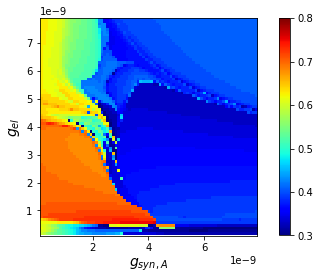

In [5]:
fontsize = 14
fig = plt.figure(figsize=(8,4))
plt.imshow(T_x_true, origin='lower', vmin=0.3, vmax=0.8, cmap='jet', extent=[g_synAs[0], g_synAs[-1], g_els[0], g_els[-1]])
ax = plt.gca()
plt.colorbar()
plt.xlabel(r'$g_{syn,A}$', fontsize=fontsize)
plt.ylabel(r'$g_{el}$', fontsize=fontsize)
plt.show()

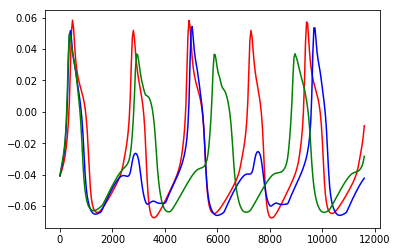

In [66]:
g_el = 1.0e-9
g_synA = 1.0e-9
x_fast = true_sys.simulate(g_el, g_synA, g_synB)

g_el = 4.0e-9
g_synA = 4.0e-9
x_slow = true_sys.simulate(g_el, g_synA, g_synB)

g_el = 6.0e-9
g_synA = 1.5e-9
x_med = true_sys.simulate(g_el, g_synA, g_synB)

t = np.arange(T+1) / dt
plt.figure()
plt.plot(t, x_fast[:,2], 'r')
plt.plot(t, x_slow[:,2], 'b')
plt.plot(t, x_med[:,2], 'g')
plt.show()

In [75]:
X = np.concatenate((x_fast, x_slow, x_med), axis=0)
print(X.shape)

(873, 15)


(873, 15)
[7.80925999e-02 3.64562879e-02 2.20541367e-02 1.32066472e-02
 7.59124493e-03 6.83965782e-04 5.37238925e-04 4.10682535e-04
 3.06497876e-04 1.93170863e-04 1.09071433e-04 7.42413863e-05
 4.84267975e-05 4.10135553e-05 1.18858218e-05]


<StemContainer object of 3 artists>

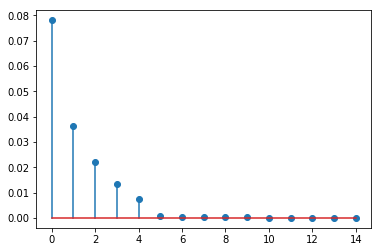

In [63]:
def PCA(data, dims_rescaled_data=2):
    """
    returns: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """
    import numpy as NP
    from scipy import linalg as LA
    m, n = data.shape
    # mean center the data
    data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = NP.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric,
    # the performance gain is substantial
    evals, evecs = LA.eigh(R)
    # sort eigenvalue in decreasing order
    idx = NP.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    # sort eigenvectors according to same index
    evals = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :dims_rescaled_data]
    # carry out the transformation on the data using eigenvectors
    # and return the re-scaled data, eigenvalues, and eigenvectors
    return NP.dot(evecs.T, data.T).T, evals, evecs

X_PCs, evals, evecs = PCA(X, 15)
print(X_PCs.shape)
print(evals)
plt.stem(evals)

['D=1', 'D=2', 'D=3', 'D=4', 'D=5']


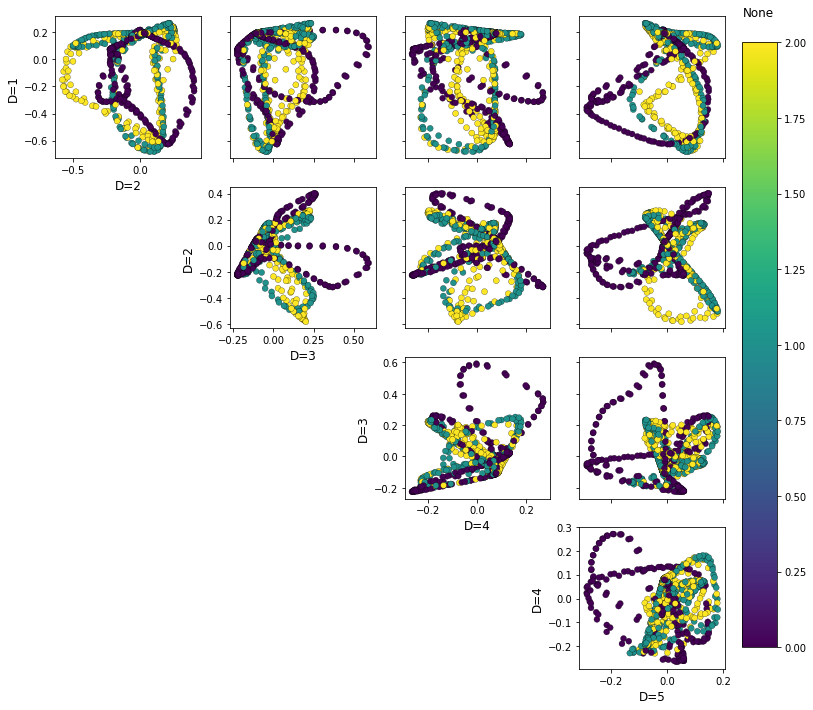

In [85]:
from dsn.util.plot_util import pairplot
X_PCs_fast = X_PCs[:(T+1),:]
X_PCs_slow = X_PCs[(T+1):,:]
X_PCs_med = X_PCs[2*(T+1):,:]
labels = ["D=%d" % i for i in range(1, 6)]
print(labels)
c = np.concatenate((np.zeros((T+1,)), np.ones((T+1,)), 2*np.ones((T+1,))), axis=0)
fig = pairplot(X_PCs, range(5), c=c, labels=labels)

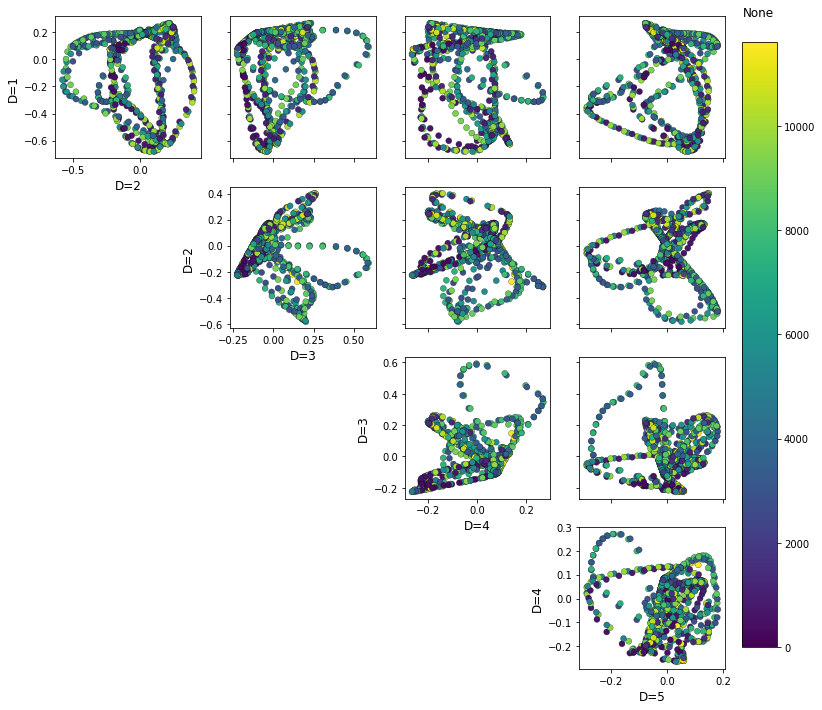

In [87]:
c = np.concatenate((t, t, t), axis=0)
fig = pairplot(X_PCs, range(5), c=c, labels=labels)

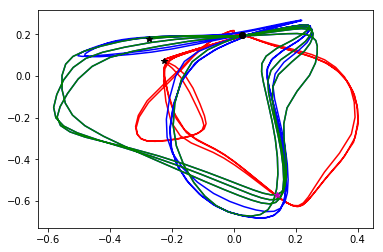

In [93]:
plt.plot(X_PCs_fast[:,1], X_PCs_fast[:,0], 'r')
plt.plot(X_PCs_fast[0,1], X_PCs_fast[0,0], 'ko')
plt.plot(X_PCs_fast[-1,1], X_PCs_fast[-1,0], 'k*')
plt.plot(X_PCs_slow[:,1], X_PCs_slow[:,0], 'b')
plt.plot(X_PCs_slow[0,1], X_PCs_slow[0,0], 'ko')
plt.plot(X_PCs_slow[-1,1], X_PCs_slow[-1,0], 'k*')
plt.plot(X_PCs_med[:,1], X_PCs_med[:,0], 'g')
plt.plot(X_PCs_med[0,1], X_PCs_med[0,0], 'ko')
plt.plot(X_PCs_med[-1,1], X_PCs_med[-1,0], 'k*')

init_time_ind = 90
plt.plot(X_PCs_med[init_time_ind,1], X_PCs_med[init_time_ind,0], 'm*')

In [94]:
print(x_med[init_time_ind])

[-0.03140991 -0.03494656 -0.00886472 -0.06851396  0.00570002  0.00375753
  0.11949047  0.57696811  0.02869717  0.5140996   0.07868617  0.04647705
  0.0502322   0.09902459  0.0524811 ]
